In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy as sp
%load_ext autoreload
%autoreload 2

# data path, constants, etc.
import sys
datapath = '/Users/nhamilto/Documents/ATom/coderepo/ATom/'
sys.path.append(datapath)

# plot things
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

# Acoustic tomography functions
import atom_functions as atom

## instantiate an at dataset 

In [2]:
test = atom.dataset('/Users/nhamilto/Documents/ATom/data/20180913_Data_collection/')
test.load_data_sample(0)

In [4]:
upsamplefactor = 5
window_width = 3
searchLag = test.meta.chirp_record_length * upsamplefactor * window_width
windowshift = (window_width - 1) / (2 * window_width)
speaker_signal_delay = test.meta.speaker_signal_delay * upsamplefactor
test.estimate_travel_times()
test.signal_ETA_index = (test.expected_tt_index.T * upsamplefactor + speaker_signal_delay).T

speakersamp = test.speaker_data.xs('frame 0', level=0)
speakersamp = atom.upsample(speakersamp, upsamplefactor)

lowcut = 1000 * (test.meta.chirp_freq - 1 * test.meta.chirp_bandWidth / 2)
hicut = 1000 * (test.meta.chirp_freq + 1 * test.meta.chirp_bandWidth / 2)
fs = test.meta.main_sampling_freq#*upsamplefactor

micsamp = test.mic_data.xs('frame 0', level=0)
micfilt = atom.butter_bandpass_filter(micsamp.values, lowcut, hicut, fs)
micsamp = pd.DataFrame(data=micfilt, columns=micsamp.columns, index=micsamp.index)
micsamp = atom.upsample(micsamp, upsamplefactor)

speakersigs = atom.signalOnSpeaker(speakersamp, searchLag, window_width, speaker_signal_delay)
# speakersigs['S3'] = atom.rollchannel(
#             speakersigs['S3'],
#             int(searchLag*windowshift))

window_indices = atom.mic_signal_window(
            micsamp, speakersigs,
            test.signal_ETA_index, searchLag, window_width)

frames = list(test.speaker_data.index.unique(level=0))
nframes = len(frames)

# allocate space for travel times between each speaker/mic combo
offset = np.zeros((test.meta.nspeakers, test.meta.nmics,
                         nframes))
index_received = np.zeros((test.meta.nspeakers, test.meta.nmics,
                             nframes))
# allocate space for received signals (nspeakers, nmics, ndata, nframes)
micsigs = np.zeros((test.meta.nspeakers, test.meta.nmics,
                         searchLag, nframes))
        
for nframe, frame in enumerate(frames):
    
    micsamp = test.mic_data.xs(frame, level=0)
#     micfilt = atom.butter_bandpass_filter(micsamp.values, lowcut, hicut, fs)
#     micsamp = pd.DataFrame(data=micfilt, columns=micsamp.columns, index=micsamp.index)
    
    micsamp = atom.freq_filter(micsamp, test.meta.filter_freq_inds)
    
    micsamp = atom.upsample(micsamp, upsamplefactor)

    micsigs[...,nframe], index_received[...,nframe], offset[...,nframe] = atom.signalOnMic(micsamp, speakersigs,
                                      window_indices, searchLag,
                                      test.signal_ETA_index)

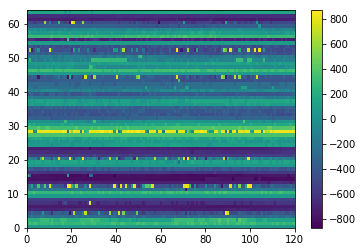

In [5]:
# pdata = offset.reshape(64,-1)
plt.pcolor(offset.reshape(64,-1))
plt.colorbar()

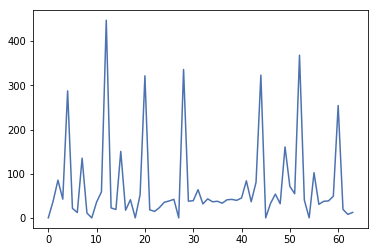

In [6]:
plt.plot(offset.reshape(64,-1).std(axis=1))

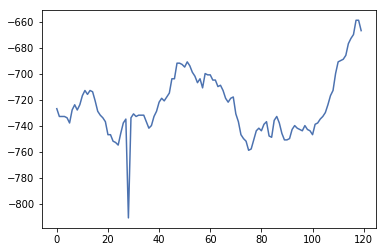

In [21]:
pdata = offset.reshape(64,-1)

signum= 23 
sigdat = pdata[signum,:]
plt.plot(sigdat)


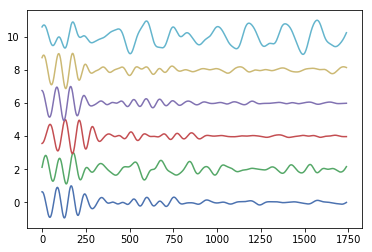

In [36]:
outliers = np.argwhere(sigdat<-780)

a,b,c,d = micsigs.shape
tmp = micsigs.reshape(a*b,c,d)

jj = np.random.randint(0,120,5)
for nj, j in enumerate(jj):
    
    plt.plot(tmp[signum,:,j]/tmp[signum,:,j].max() + 2*nj)

plt.plot(tmp[signum,:,outliers[0]].T/tmp[signum,:,outliers[0]].max() + 10)


162


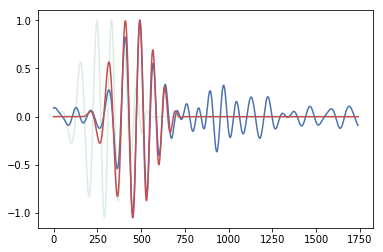

In [258]:
msc = micsigs[int(signum/8),signum%8,:,minlag]
sps = speakersigs.iloc[:,int(signum/8)].values

covar = np.correlate(msc, sps, mode='same')

plt.plot(msc/msc.max())
plt.plot(sps/sps.max(), alpha=0.2)
# plt.plot(covar/covar.max())

plt.plot(np.roll(sps/sps.max(), int(np.argmax(covar)-searchLag/2)))
print(int(np.argmax(covar)-searchLag/2))

In [59]:
# filter comparison
upsamplefactor = 5
window_width = 3
searchLag = test.meta.chirp_record_length * upsamplefactor * window_width
windowshift = (window_width - 1) / (2 * window_width)
speaker_signal_delay = test.meta.speaker_signal_delay * upsamplefactor

micsamp = test.mic_data.xs('frame 0', level=0)

# frequency filters
fftfilt = atom.freq_filter(micsamp, test.meta.filter_freq_inds)

lowcut = 1000 * (test.meta.chirp_freq - 1 * test.meta.chirp_bandWidth / 2)
hicut = 1000 * (test.meta.chirp_freq + 1 * test.meta.chirp_bandWidth / 2)
butterfilt = atom.butter_bandpass_filter(micsamp, lowcut, hicut, fs)
butterfilt = pd.DataFrame(data=butterfilt, columns=micsamp.columns, index=micsamp.index)

lowcut = 1000 * (test.meta.chirp_freq - 1 * test.meta.chirp_bandWidth / 2)
hicut = 1000 * (test.meta.chirp_freq + 1 * test.meta.chirp_bandWidth / 2)
butterfilt2 = atom.butter_bandpass_filter(micsamp, lowcut, hicut, fs, order=8)
butterfilt2 = pd.DataFrame(data=butterfilt2, columns=micsamp.columns, index=micsamp.index)

lowcut = 1000 * (test.meta.chirp_freq - 3 * test.meta.chirp_bandWidth / 2)
hicut = 1000 * (test.meta.chirp_freq + 3 * test.meta.chirp_bandWidth / 2)
butterfilt3 = atom.butter_bandpass_filter(micsamp, lowcut, hicut, fs,order=3)
butterfilt3 = pd.DataFrame(data=butterfilt3, columns=micsamp.columns, index=micsamp.index)

# upsample
micsamp = atom.upsample(micsamp, upsamplefactor)
fftfilt = atom.upsample(fftfilt, upsamplefactor)
butterfilt = atom.upsample(butterfilt, upsamplefactor)
butterfilt2 = atom.upsample(butterfilt2, upsamplefactor)
butterfilt3 = atom.upsample(butterfilt3, upsamplefactor)

window_indices = atom.mic_signal_window(
            micsamp, speakersigs,
            test.signal_ETA_index, searchLag, window_width)

rawdat = micsamp['M0'].iloc[window_indices['M0']['S5'][0]:window_indices['M0']['S5'][1]].values
ffdat = fftfilt['M0'].iloc[window_indices['M0']['S5'][0]:window_indices['M0']['S5'][1]].values
butterdat = butterfilt['M0'].iloc[window_indices['M0']['S5'][0]:window_indices['M0']['S5'][1]].values
butterdat2 = butterfilt2['M0'].iloc[window_indices['M0']['S5'][0]:window_indices['M0']['S5'][1]].values
butterdat3 = butterfilt3['M0'].iloc[window_indices['M0']['S5'][0]:window_indices['M0']['S5'][1]].values

In [60]:
rawind = searchLag-np.argmax(np.correlate(speakersigs['S5'].values, rawdat, mode='same'))
fftind = searchLag-np.argmax(np.correlate(speakersigs['S5'].values, ffdat, mode='same'))
btterind = searchLag-np.argmax(np.correlate(speakersigs['S5'].values, butterdat, mode='same'))
btterind2 = searchLag-np.argmax(np.correlate(speakersigs['S5'].values, butterdat2, mode='same'))
btterind3 = searchLag-np.argmax(np.correlate(speakersigs['S5'].values, butterdat3, mode='same'))

In [64]:
print(rawind, fftind, btterind, btterind2, btterind3)

827 827 917 1003 838


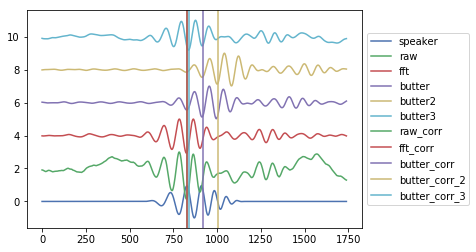

In [61]:
plt.plot(speakersigs['S5'].values, label='speaker')
plt.plot(rawdat/rawdat.max()+2, label='raw')
plt.plot(ffdat/ffdat.max()+4, label='fft')
plt.plot(butterdat/butterdat.max()+6, label='butter')
plt.plot(butterdat2/butterdat2.max()+8, label='butter2')
plt.plot(butterdat3/butterdat3.max()+10, label='butter3')


plt.axvline(rawind, color='C1', label='raw_corr')
plt.axvline(fftind, color='C2', label='fft_corr')
plt.axvline(btterind, color='C3', label='butter_corr')
plt.axvline(btterind2, color='C4', label='butter_corr_2')
plt.axvline(btterind3, color='C5', label='butter_corr_3')

plt.legend(loc=6, bbox_to_anchor=(1,0.5))

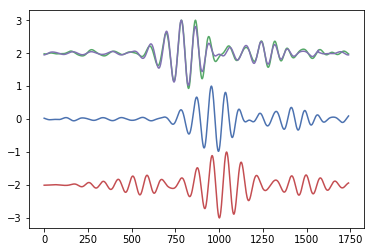

In [56]:
plt.plot(butterdat/butterdat.max())
plt.plot(ffdat/ffdat.max()+2)
covar = np.correlate(butterdat, ffdat, mode='same')
plt.plot(covar/covar.max()-2)

rollval = int(searchLag/2-np.argmax(covar))
butterroll = np.roll(butterdat/butterdat.max(), rollval)
plt.plot(butterroll+2)

In [219]:
micsamp = test.mic_data.xs('frame 0', level=0)

# filter comparison
upsamplefactor = 2
window_width = 3
searchLag = test.meta.chirp_record_length * upsamplefactor * window_width
windowshift = (window_width - 1) / (2 * window_width)
speaker_signal_delay = test.meta.speaker_signal_delay * upsamplefactor

fftfilt = atom.freq_filter(micsamp, test.meta.filter_freq_inds)
fftfilt = atom.upsample(fftfilt, upsamplefactor)

lowcut = 1000 * (test.meta.chirp_freq - 1 * test.meta.chirp_bandWidth / 2)
hicut = 1000 * (test.meta.chirp_freq + 1 * test.meta.chirp_bandWidth / 2)
butterfilt = atom.butter_bandpass_filter(micsamp, lowcut, hicut, fs, fixtimedelay=False)
butterfilt = pd.DataFrame(data=butterfilt, columns=micsamp.columns, index=micsamp.index)
butterfilt = atom.upsample(butterfilt, upsamplefactor)

window_indices = atom.mic_signal_window(
            micsamp, speakersigs,
            test.signal_ETA_index, searchLag, window_width)

td = np.zeros(100)
rv = np.zeros(100)
for ii in range(100):
#     sn = np.random.randint(8)
#     mn = np.random.randint(8)
    
    ffdat = fftfilt['M{}'.format(mn)].iloc[window_indices['M{}'.format(mn)]['S{}'.format(sn)][0]:window_indices['M{}'.format(mn)]['S{}'.format(sn)][1]].values
    butterdat = butterfilt['M{}'.format(mn)].iloc[window_indices['M{}'.format(mn)]['S{}'.format(sn)][0]:window_indices['M{}'.format(mn)]['S{}'.format(sn)][1]].values

    covar = np.correlate(butterdat, ffdat, mode='same')
    rollval = int(searchLag/2-np.argmax(covar))
    rv[ii] = rollval
#     plt.plot(ffdat/ffdat.max()+2*ii, color='C0')
#     plt.plot(np.roll(butterdat/butterdat.max()+2*ii, rollval), color='C1')
    
    time_delay = rollval/(test.meta.main_sampling_freq*upsamplefactor)
    td[ii] = time_delay
#     print(time_delay)

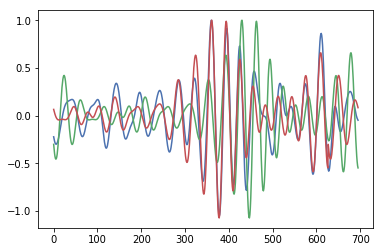

In [220]:
plt.plot(ffdat/ffdat.max(), color='C0')
plt.plot(butterdat/butterdat.max(), color='C1')

plt.plot(np.roll(butterdat/butterdat.max(), rollval), color='C2')

In [213]:
rollval

-69

In [212]:
print(td.mean(), rv.mean())

-0.0017250000000000006 -69.0


In [214]:
td_exp = {
        k: v
        for k, v in zip(
            np.arange(2, 11), np.array([0.225, 0.318, 0.416, 0.515, 0.615,
                                       0.715, 0.816, 0.917, 1.017]))
    }
td_exp = td_exp[5] / hicut
print(td_exp)
rv_exp = td_exp*test.meta.main_sampling_freq*upsamplefactor
print(rv_exp)

0.0003322580645161291
13.290322580645164


0.0003322580645161291


In [160]:
td_exp*(test.meta.main_sampling_freq*upsamplefactor)

TypeError: unsupported operand type(s) for *: 'dict' and 'int'

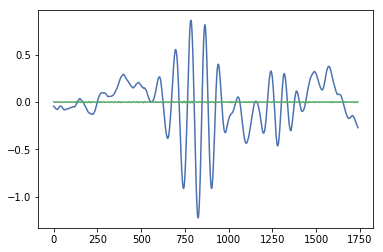

In [70]:
plt.plot(ffdat)
plt.plot(butterdat)

In [62]:
indexes = find_peaks_cwt(speakersigs['S5'].values, [1,20])
tmp = speakersigs['S5'].values[indexes]
print('spsratio =', sorted(tmp)[-1]/sorted(tmp)[-2])
indexes = find_peaks_cwt(ffdat, [1,20])
tmp = ffdat[indexes]
print('fftratio =', sorted(tmp)[-1]/sorted(tmp)[-2])

indexes = find_peaks_cwt(butterdat, [1,20])
tmp = butterdat[indexes]
print('butterratio =', sorted(tmp)[-1]/sorted(tmp)[-2])

indexes = find_peaks_cwt(butterdat2, [1,20])
tmp = butterdat2[indexes]
print('butterratio2 =', sorted(tmp)[-1]/sorted(tmp)[-2])

indexes = find_peaks_cwt(butterdat3, [1,20])
tmp = butterdat3[indexes]
print('butterratio3 =', sorted(tmp)[-1]/sorted(tmp)[-2])



spsratio = 1.006622536174988
fftratio = 1.001685314352629
butterratio = 1.2397421345059467
butterratio2 = 1.0045427032356042
butterratio3 = 1.0010427613587203


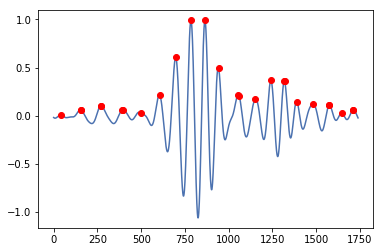

In [361]:
plt.plot(ffdat)

plt.plot(indexes, ffdat[indexes], 'or')
# ffdat

In [327]:
print(rawind, fftind, btterind, btterind2)

827 827 917 840


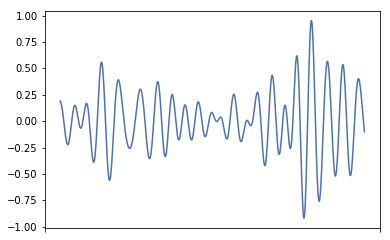

In [221]:
micsamp=test.mic_data.xs('frame 17', level=0)

lowcut = 1000 * (test.meta.chirp_freq - 1 * test.meta.chirp_bandWidth / 2)
hicut = 1000 * (test.meta.chirp_freq + 1 * test.meta.chirp_bandWidth / 2)

micfilt = atom.butter_bandpass_filter(micsamp, lowcut, hicut, fs)
micsamp = pd.DataFrame(data=micfilt, columns=micsamp.columns, index=micsamp.index)
micsamp = atom.upsample(micsamp, upsamplefactor)
micsamp['M0'].iloc[window_indices['M0']['S5'][0]:window_indices['M0']['S5'][1]].plot()

In [222]:
plt.plot(tmp[5,:,4])
plt.plot(tmp[5,:,13])

IndexError: too many indices for array

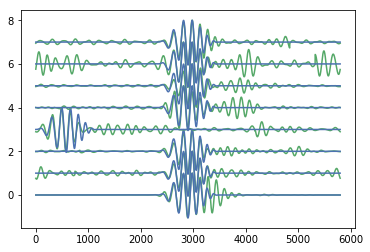

In [148]:
for ii in range(8):
    pdat = np.roll(micsigs[ii,0,:], -int(offset[ii,0]))
    pdat /= pdat.max()
    plt.plot(pdat+ii, color='C1')

    pdat = speakersigs.values[:,ii]
    pdat /= pdat.max()
    plt.plot(pdat+ii, color='C0')

### extract travel times for a few upsample factors

In [224]:
atomsigs1, tt1, tr1 = test.extract_travel_times(upsamplefactor=1)
atomsigs5, tt5, tr5 = test.extract_travel_times(upsamplefactor=5)
# atomsigs10, tt10, tr10 = test.extract_travel_times(upsamplefactor=10)

In [228]:
(tr5.mean(axis=2)-tr1.mean(axis=2)).round(2)

array([[-4.0270e+01, -8.8620e+01,  1.5187e+02,  2.2694e+02,  1.6294e+02,
        -2.5680e+01, -2.2466e+02,  1.1865e+02],
       [ 2.0021e+02, -5.7550e+01,  2.6017e+02,  2.4694e+02, -1.0347e+02,
        -3.3419e+02, -2.0830e+01,  2.6670e+01],
       [ 5.0090e+01,  2.0322e+02, -1.6833e+02, -2.2640e+01, -4.5920e+01,
        -1.7197e+02,  2.5161e+02, -1.7112e+02],
       [ 4.7190e+01, -9.4310e+01,  1.8407e+02, -2.8000e-01,  3.7000e-01,
         6.7160e+01,  2.0032e+02,  2.3179e+02],
       [ 1.1710e+01,  1.9800e+01,  9.1090e+01,  1.8878e+02, -3.7800e+00,
        -1.4375e+02,  7.1280e+01, -4.4300e+01],
       [ 1.8314e+02, -2.3860e+01,  1.1832e+02,  1.6032e+02, -2.2365e+02,
        -2.1471e+02,  1.5927e+02,  9.5360e+01],
       [-3.5420e+01, -4.7080e+01,  3.3072e+02,  2.8450e+02, -1.3871e+02,
        -1.6832e+02, -6.3700e+00,  6.0590e+01],
       [-9.2260e+01,  2.0242e+02,  3.3059e+02, -1.7200e+00,  7.7030e+01,
        -2.9211e+02, -1.0273e+02,  7.0040e+01]])

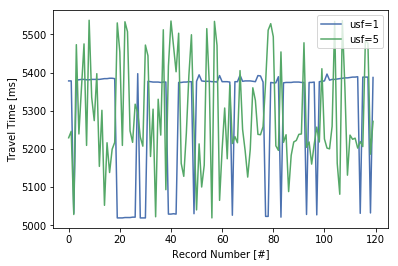

In [237]:
spknum = np.random.randint(8)
micnum = np.random.randint(8)

tmp1 = tr1[spknum,micnum,:] # np.squeeze(tt1[spknum, micnum, :])
tmp5 = tr5[spknum,micnum,:] # np.squeeze(tt5[spknum, micnum, :])
# tmp10 = tr10[spknum,micnum,:] # np.squeeze(tt10[spknum, micnum, :])

fig,ax = plt.subplots()
ax.plot(tmp1, label='usf=1')
ax.plot(tmp5, label='usf=5')
# ax.plot(tmp10, label='usf=10')
ax.set_xlabel('Record Number [#]')
ax.set_ylabel('Travel Time [ms]')
ax.legend()

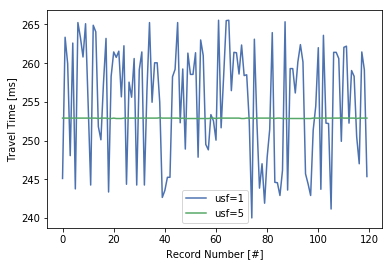

In [242]:
spknum = 'S{}'.format(np.random.randint(0,8,1)[0])
micnum = 'M{}'.format(np.random.randint(0,8,1)[0])

tmp1 = tt1.loc[(spknum, micnum)].values # np.squeeze(tt1[spknum, micnum, :])
tmp5 = tt5.loc[(spknum, micnum)].values # np.squeeze(tt5[spknum, micnum, :])
# tmp10 = tt10.loc[(spknum, micnum)].values # np.squeeze(tt10[spknum, micnum, :])

fig,ax = plt.subplots()
ax.plot(tmp1, label='usf=1')
ax.plot(tmp5, label='usf=5')
# ax.plot(tmp10, label='usf=10')
ax.set_xlabel('Record Number [#]')
ax.set_ylabel('Travel Time [ms]')
ax.legend()

In [10]:
test.expected_tt_time*1000

array([[  2.07403414,  91.888457  , 132.14963928, 222.59713044,
        235.65173002, 238.65591155, 200.7255047 , 123.64774449],
       [ 95.18655589,   2.05887274,  70.3504314 , 193.02535244,
        232.81888595, 277.89479784, 265.43931756, 213.92171976],
       [135.46219609,  74.35290163,   2.08784915, 122.74441515,
        171.17139878, 238.87521562, 248.38777914, 233.03626998],
       [224.37265367, 196.04260765, 126.24606673,   2.09446393,
         67.68169191, 177.15555711, 228.28474697, 274.93506554],
       [236.42037662, 234.9889811 , 174.07249769,  71.65271178,
          2.02769516, 113.96147073, 179.53622021, 254.1096782 ],
       [237.65240577, 278.42518153, 240.34558905, 180.31038253,
        117.5961444 ,   2.07925682,  82.83416771, 196.54430947],
       [198.50343422, 264.64058133, 248.52205145, 230.35886591,
        182.38472676,  86.68039988,   2.00752347, 122.39436157],
       [119.92668491, 211.24183055, 231.07489855, 274.95419411,
        255.15477239, 199.1710886

AttributeError: 'DataFrame' object has no attribute 'reshape'

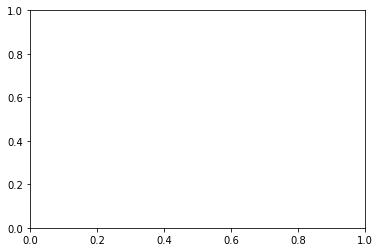

In [14]:
fig,ax1 = plt.subplots()
tra = tt1.reshape(64,122)
p1=ax1.pcolor(tra)
fig.colorbar(p1)

fig,ax2 = plt.subplots()
tra = tt5.reshape(64,122)
p1=ax2.pcolor(tra)
fig.colorbar(p1)

fig,ax2 = plt.subplots()
tra = tt10.reshape(64,122)
p1=ax2.pcolor(tra)
fig.colorbar(p1)


In [124]:
micsamp = test.mic_data.xs('record 1', level=0)
miscamp = atom.freq_filter(micsamp, test.meta.filter_freq_inds)
speakersamp = test.speaker_data.xs('record 1', level=0)
speaker_signal_delay = atom.get_speaker_signal_delay(speakersamp)
upsamplefactor=1
searchLag = 3 * test.meta.chirp_record_length * upsamplefactor


In [135]:
ups = atom.upsample(speakersamp, 5)

In [187]:
speaker_signal_delay = atom.get_speaker_signal_delay(speakersamp)*5
# print(speaker_signal_delay*5)
# speaker_signal_delay = atom.get_speaker_signal_delay(ups)
print(speaker_signal_delay)

[12400 10400 20400     0 16000 20000  4000 14400]


In [153]:
for ic, col in enumerate(speakersamp.columns):
    speaker_signal_delay[ic] = ups[col].nonzero()[0][0] 
speaker_signal_delay = speaker_signal_delay.astype(int)

In [154]:
speaker_signal_delay

array([ 9611,  7611, 17611,     1, 13211, 17211,  1211, 11611])

NameError: name 'ups' is not defined

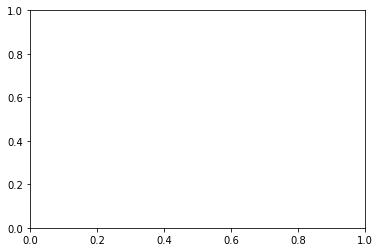

In [243]:
fig,ax = plt.subplots()
ax.plot(np.arange(0,1,1/len(ups.iloc[:,0])),ups.iloc[:, 0].values)
ax.axvline(speaker_signal_delay[0]/ups.shape[0], color='C2')
# ax.set_xlim(12000,13500)
ax.plot(np.arange(0,1,1/len(speakersamp.iloc[:,0])),speakersamp.iloc[:,0].values)

record: 1
eta - obs: 39.0


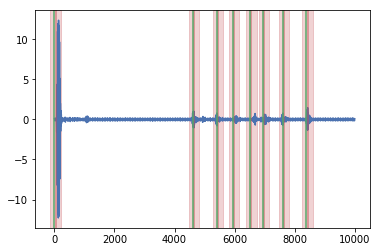

In [4]:
fig,ax = plt.subplots()
recnum = np.random.randint(0, 122, 1)[0]
micsamp = test.mic_data.xs('record {}'.format(recnum), level=0)
micsamp = atom.freq_filter(micsamp, test.meta.filter_freq_inds)
micnum=3
ax.plot(micsamp['M{}'.format(micnum)].values)
for ii in range(8):
    ax.axvline(test.signalETAs[ii,micnum], color='C2', alpha=0.6)
    start = (test.signalETAs[ii,micnum]+(0*test.meta.chirp_record_length - searchLag) / 2).astype(int)
    stop = start + searchLag
    ax.axvspan(start,stop, alpha=0.25, color ='C2')
    ax.axvline(tr[ii,micnum,recnum], color='C1')

# ax.set_xlim(0,500)
print('record: {}'.format(recnum))
print('eta - obs: {}'.format((test.signalETAs[:,micnum] - tr[:, micnum,recnum]).mean()))


In [82]:
jtt = np.genfromtxt('../ttout.txt')
srout = np.load('../s_rout.npy')

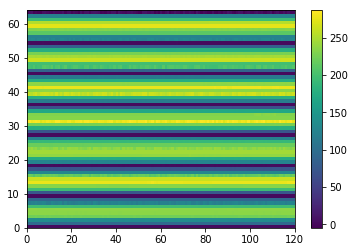

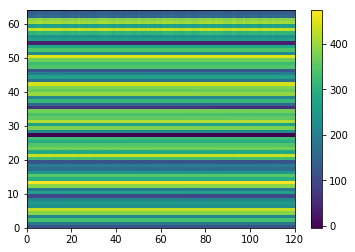

In [45]:
fig,ax = plt.subplots()
aa = ax.pcolor(jtt)
fig.colorbar(aa)

fig,ax = plt.subplots()
aa=ax.pcolor(tt.swapaxes(0,1).reshape(64,122)[:,:-2])
fig.colorbar(aa)


In [53]:
channelnum

array([16])

Text(0,0.5,'james')

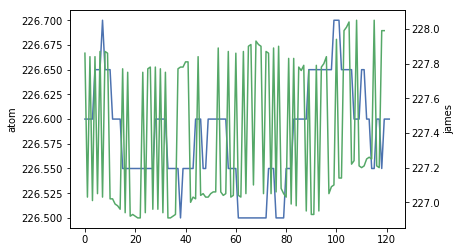

In [58]:
speakernum = np.random.randint(0,8,1)
micnum = np.random.randint(0,8,1)

channelnum = int(8*speakernum + micnum)

fig,ax = plt.subplots()
ax.plot(tt.swapaxes(0,1).reshape(64,122)[channelnum,:].T)
ax.set_ylabel('atom')
ax2 = ax.twinx()
ax2.plot(jtt[channelnum,:],color='C1')
ax2.set_ylabel('james')


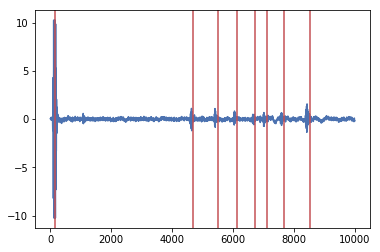

In [35]:
recordnum = 4
mictest = test.mic_data.xs('record {}'.format(recordnum), level=0)
fig, ax = plt.subplots()
ax.plot(mictest['M3'].values)
for jj in range(8):
    ax.axvline(tr[3,jj,recordnum],color='C2')

In [28]:
tr.reshape(64,122)[27,:-2].mean(-1)

81.56666666666666

In [30]:
test.signalETAs

array([[2522, 3935, 6747, 4493, 7956, 8817, 4851, 5376],
       [4388, 2122, 5497, 3890, 7890, 9596, 6143, 7184],
       [5214, 3581, 4122, 2477, 6655, 8821, 5813, 7583],
       [7001, 6030, 6621,   42, 4566, 7573, 5402, 8422],
       [7252, 6823, 7593, 1446, 3241, 6300, 4423, 8009],
       [7276, 7699, 8931, 3639, 5573, 4042, 2472, 6847],
       [6486, 7421, 9096, 4649, 6881, 5749,  841, 5350],
       [4900, 6343, 8744, 5549, 8350, 8020, 3338, 2922]])

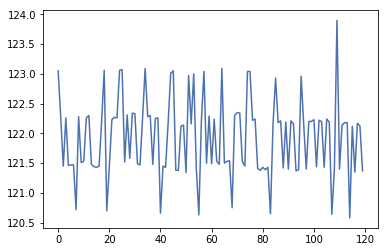

In [33]:

plt.plot(tr.reshape(64,122)[26,:-2])
plt.plot(jtt[26,:])#/(1000*test.meta.main_delta_t))

In [25]:
test.meta.main_delta_t

0.05

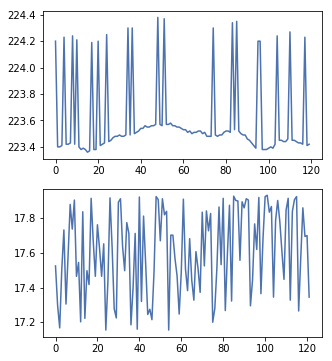

In [17]:
times = np.swapaxes(tt,0,1).reshape(64,122)*test.meta.main_delta_t

ii = 3
fig,ax = plt.subplots(2,1, figsize=(5,6))
ax[0].plot(jtt[ii,:])
ax[1].plot(times[ii,:])
# 


In [4]:
micsamp = test.mic_data.xs('record 0', level=0)
speakersamp = test.speaker_data.xs('record 0', level=0)

In [5]:
import imp
imp.reload(atom)

<module 'atom_functions_v1' from '/Users/nhamilto/Documents/ATom/coderepo/atom_functions_v1.py'>

In [6]:
micsamp = atom.freq_filter(micsamp, test.meta.filter_freq_inds)

(7500, 8250)

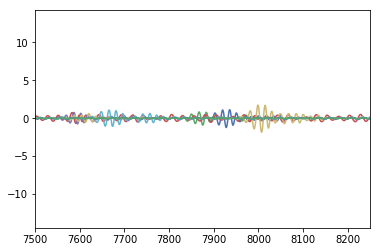

In [10]:
fig, ax = plt.subplots()
ax.plot(micsamp.values)
ax.set_xlim(7500, 8250)

In [11]:
m1 = micsamp['M0']
s1 = speakersamp['S0']

In [13]:
covar = atom.covariance(micsamp, speakersamp)

In [27]:
c1 = covar[0,0,:]
c1r = np.roll(c1,int(len(c1)/2))

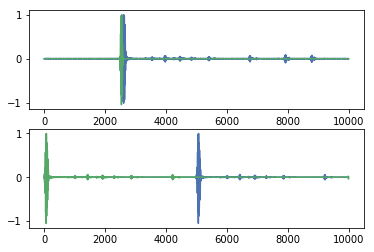

In [28]:
fig, ax = plt.subplots(2,1)

ax[0].plot(m1.values/m1.max())
ax[0].plot(s1.values/s1.max())
ax[1].plot(c1/c1.max())
ax[1].plot(c1r/c1.max())

# ax.set_xlim(7500, 8250)


In [29]:
np.argmax(c1)

5073

In [39]:
speaker_signal_delay = atom.get_speaker_signal_delay(speakersamp)
signalETAs = (speaker_signal_delay + test.ETAs_index.T).T

In [40]:
signalETAs

array([[2480, 2482, 2483, 2484, 2485, 2485, 2484, 2482],
       [2082, 2080, 2081, 2084, 2085, 2086, 2085, 2084],
       [4083, 4082, 4080, 4082, 4083, 4085, 4085, 4085],
       [   5,    4,    3,    0,    1,    4,    5,    6],
       [3205, 3205, 3204, 3201, 3200, 3202, 3204, 3205],
       [4005, 4006, 4005, 4004, 4002, 4000, 4002, 4004],
       [ 804,  805,  805,  805,  804,  802,  800,  802],
       [2882, 2884, 2885, 2886, 2885, 2884, 2883, 2880]])

In [45]:
test.ETAs_index

array([[0, 2, 3, 4, 5, 5, 4, 2],
       [2, 0, 1, 4, 5, 6, 5, 4],
       [3, 2, 0, 2, 3, 5, 5, 5],
       [5, 4, 3, 0, 1, 4, 5, 6],
       [5, 5, 4, 1, 0, 2, 4, 5],
       [5, 6, 5, 4, 2, 0, 2, 4],
       [4, 5, 5, 5, 4, 2, 0, 2],
       [2, 4, 5, 6, 5, 4, 3, 0]])

In [57]:
(test.ETAs_time/(test.meta.main_delta_t/1000)).round().astype(int)

array([[  42, 1855, 2667, 4493, 4756, 4817, 4051, 2496],
       [1908,   42, 1417, 3890, 4690, 5596, 5343, 4304],
       [2734, 1501,   42, 2477, 3455, 4821, 5013, 4703],
       [4521, 3950, 2541,   42, 1366, 3573, 4602, 5542],
       [4772, 4743, 3513, 1446,   41, 2300, 3623, 5129],
       [4796, 5619, 4851, 3639, 2373,   42, 1672, 3967],
       [4006, 5341, 5016, 4649, 3681, 1749,   41, 2470],
       [2420, 4263, 4664, 5549, 5150, 4020, 2538,   42]])

In [ ]:
test.ETAs_index + 

In [51]:
signalstarts = np.array([int(s) if s > 0 else 0 for s in (test.ETAs_index[:,0] + test.meta.chirp_record_length) ])#-


# for si in range(8):
#     startind = test.ETAs_index[si,0]
    
#     print(np.argmax(c1r[]))

In [52]:
signalstarts

array([116, 118, 119, 121, 121, 121, 120, 118])

In [32]:
upsamplefactor=1
searchLag = 3 * test.meta.chirp_record_length * upsamplefactor

In [33]:
test.ETAs_index

array([[0, 2, 3, 4, 5, 5, 4, 2],
       [2, 0, 1, 4, 5, 6, 5, 4],
       [3, 2, 0, 2, 3, 5, 5, 5],
       [5, 4, 3, 0, 1, 4, 5, 6],
       [5, 5, 4, 1, 0, 2, 4, 5],
       [5, 6, 5, 4, 2, 0, 2, 4],
       [4, 5, 5, 5, 4, 2, 0, 2],
       [2, 4, 5, 6, 5, 4, 3, 0]])

In [34]:
searchLag

348